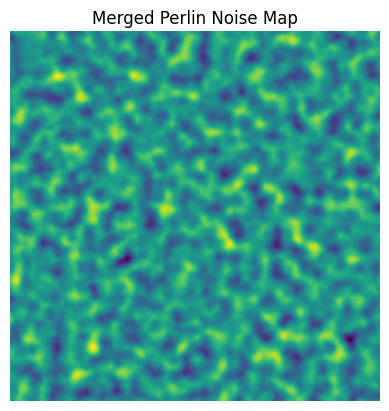

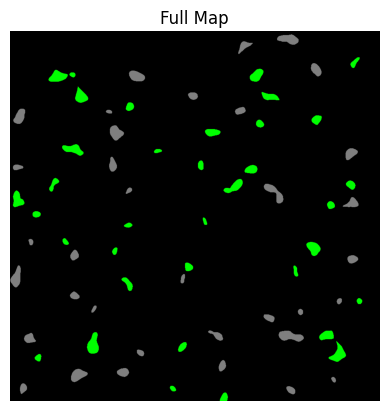

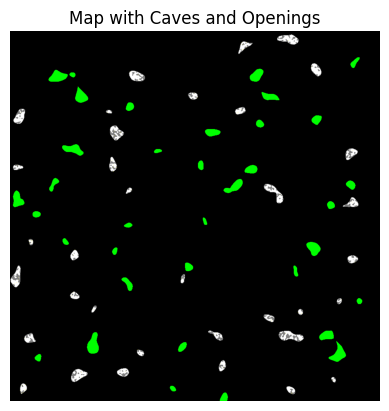

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from noise import pnoise2
from scipy.ndimage import label, find_objects
import random

# Parameters for the 2D array
width, height = 1000, 1000
scale = 50.0


# Create two 2D arrays with Perlin noise to generate an organic shape
def generate_noise_array(width, height, scale, base):
    return np.array(
        [
            [
                pnoise2(
                    i / scale,
                    j / scale,
                    octaves=3,
                    persistence=0.4,
                    lacunarity=1.5,
                    base=base,
                )
                for j in range(width)
            ]
            for i in range(height)
        ]
    )


array1 = generate_noise_array(width, height, scale, base=42)
array2 = generate_noise_array(width, height, scale, base=24)

# Merge the two Perlin noise maps for more randomness
merged_array = (array1 + array2) / 2

# Plot the merged Perlin noise map
plt.imshow(merged_array, cmap="viridis")
plt.title("Merged Perlin Noise Map")
plt.axis("off")
plt.show()

# Threshold to create a natural shape (like an island or organic blob)
threshold = 0.2
organic_shape = merged_array > threshold

# Label connected regions and analyze cluster sizes
labeled_array, num_features = label(organic_shape)
objects = find_objects(labeled_array)

# Calculate sizes of all clusters and sort by size
cluster_sizes = [
    (i + 1, np.sum(labeled_array[obj_slice] == (i + 1)))
    for i, obj_slice in enumerate(objects)
]
cluster_sizes.sort(key=lambda x: x[1])

# Determine the size thresholds for top 80% and bottom 30%
num_clusters = len(cluster_sizes)
min_index = int(num_clusters * 0.25)
max_index = int(num_clusters * 0.95)

# Filter clusters to keep only those within the middle 50% range
filtered_shape = np.zeros_like(organic_shape)
for cluster_id, size in cluster_sizes[min_index:max_index]:
    filtered_shape[labeled_array == cluster_id] = 1

# Create a random color assignment for each blob (either grey or green)
final_shape = np.zeros((height, width, 3))
for cluster_id, _ in cluster_sizes[min_index:max_index]:
    color = [0.5, 0.5, 0.5] if random.random() < 0.5 else [0, 1, 0]  # Grey or Green
    final_shape[labeled_array == cluster_id] = color

# Plot the final shape with random colors
plt.imshow(final_shape)
plt.title("Full Map")
plt.axis("off")
plt.show()

# Generate cave within each grey region using Cellular Automata
grey_regions = [
    cluster_id
    for cluster_id, _ in cluster_sizes[min_index:max_index]
    if np.all(final_shape[labeled_array == cluster_id][0] == [0.5, 0.5, 0.5])
]

for cluster_id in grey_regions:
    obj_slice = objects[cluster_id - 1]
    grey_region = labeled_array[obj_slice] == cluster_id
    cave_region = np.random.choice(
        [0, 1], size=grey_region.shape, p=[0.45, 0.55]
    )  # Initial random fill (45% walls, 55% open)

    # Apply Cellular Automata rules for several generations
    for _ in range(5):  # Number of generations
        new_cave_region = np.copy(cave_region)
        for i in range(1, cave_region.shape[0] - 1):
            for j in range(1, cave_region.shape[1] - 1):
                if grey_region[i, j]:  # Only update cells within the grey region mask
                    # Count the number of neighboring walls
                    neighbor_sum = (
                        cave_region[i - 1, j - 1]
                        + cave_region[i - 1, j]
                        + cave_region[i - 1, j + 1]
                        + cave_region[i, j - 1]
                        + cave_region[i, j + 1]
                        + cave_region[i + 1, j - 1]
                        + cave_region[i + 1, j]
                        + cave_region[i + 1, j + 1]
                    )
                    if cave_region[i, j] == 1:
                        new_cave_region[i, j] = 1 if neighbor_sum >= 4 else 0
                    else:
                        new_cave_region[i, j] = 1 if neighbor_sum >= 5 else 0
        cave_region = new_cave_region

    # Make the interior of the grey region into a cave-like structure (white is open space)
    final_shape[obj_slice][..., 0] = np.where(
        grey_region & (cave_region == 1), 1, final_shape[obj_slice][..., 0]
    )
    final_shape[obj_slice][..., 1] = np.where(
        grey_region & (cave_region == 1), 1, final_shape[obj_slice][..., 1]
    )
    final_shape[obj_slice][..., 2] = np.where(
        grey_region & (cave_region == 1), 1, final_shape[obj_slice][..., 2]
    )

    # Add a border of grey around the cave
    padded_cave = np.pad(grey_region, pad_width=1, mode="constant", constant_values=0)
    border = (
        (padded_cave[:-2, 1:-1] == 0)
        | (padded_cave[2:, 1:-1] == 0)
        | (padded_cave[1:-1, :-2] == 0)
        | (padded_cave[1:-1, 2:] == 0)
    ) & grey_region
    final_shape[obj_slice][..., 0] = np.where(
        border, 0.5, final_shape[obj_slice][..., 0]
    )
    final_shape[obj_slice][..., 1] = np.where(
        border, 0.5, final_shape[obj_slice][..., 1]
    )
    final_shape[obj_slice][..., 2] = np.where(
        border, 0.5, final_shape[obj_slice][..., 2]
    )

# Create openings (in yellow) along the boundary of the grey regions
for cluster_id in grey_regions:
    obj_slice = objects[cluster_id - 1]
    grey_region = labeled_array[obj_slice] == cluster_id
    boundary_points = np.argwhere(grey_region)

    # Randomly select 1-7 boundary points to create openings (weighted towards 1)
    num_openings = random.choices(range(1, 8), weights=[50, 20, 10, 8, 6, 4, 2], k=1)[0]
    selected_points = boundary_points[
        random.sample(range(len(boundary_points)), num_openings)
    ]

    # Mark the openings in yellow
    for point in selected_points:
        if grey_region[
            point[0], point[1]
        ]:  # Ensure the point is within the grey region mask
            final_shape[obj_slice][point[0], point[1]] = [
                1,
                1,
                0,
            ]  # Yellow for openings

# Plot the final map with caves and openings
plt.imshow(final_shape)
plt.title("Map with Caves and Openings")
plt.axis("off")
plt.show()

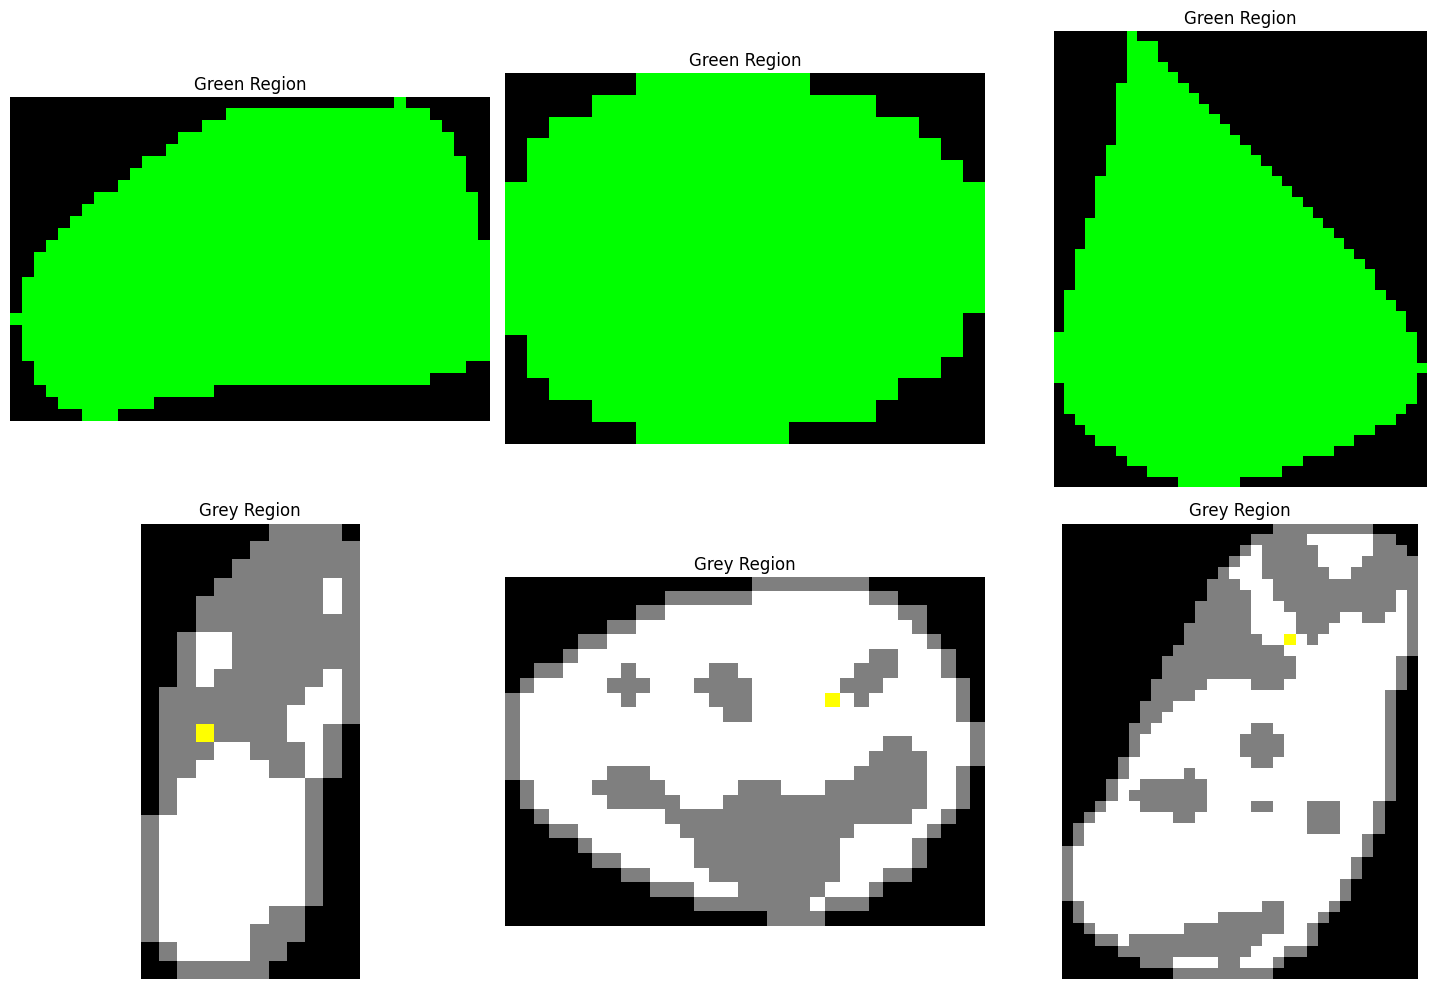

In [15]:

# Randomly pick and display three green and three grey regions
green_regions = [cluster_id for cluster_id, _ in cluster_sizes[min_index:max_index] if np.all(final_shape[labeled_array == cluster_id][0] == [0, 1, 0])]
grey_regions = [cluster_id for cluster_id, _ in cluster_sizes[min_index:max_index] if np.all(final_shape[labeled_array == cluster_id][0] == [0.5, 0.5, 0.5])]

# Ensure at least three regions are available
selected_green_regions = random.sample(green_regions, min(3, len(green_regions)))
selected_grey_regions = random.sample(grey_regions, min(3, len(grey_regions)))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Display three green regions, fitted to actual size
for idx, cluster_id in enumerate(selected_green_regions):
    obj_slice = objects[cluster_id - 1]
    green_region_display = final_shape[obj_slice]
    axes[0, idx].imshow(green_region_display)
    axes[0, idx].set_title('Green Region')
    axes[0, idx].axis('off')

# Display three grey regions, fitted to actual size
for idx, cluster_id in enumerate(selected_grey_regions):
    obj_slice = objects[cluster_id - 1]
    grey_region_display = final_shape[obj_slice]
    axes[1, idx].imshow(grey_region_display)
    axes[1, idx].set_title('Grey Region')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

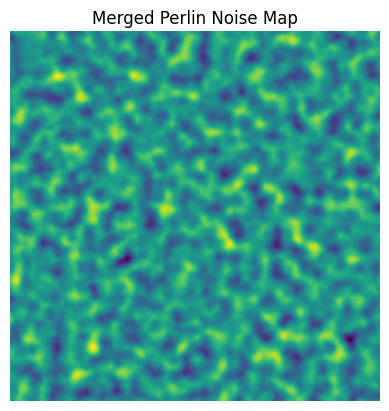

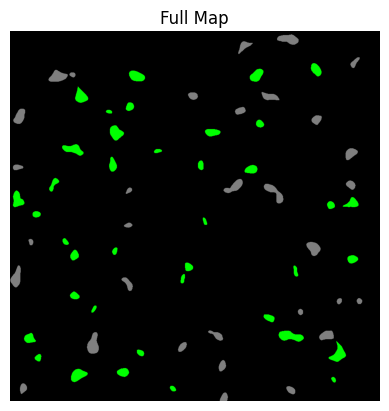

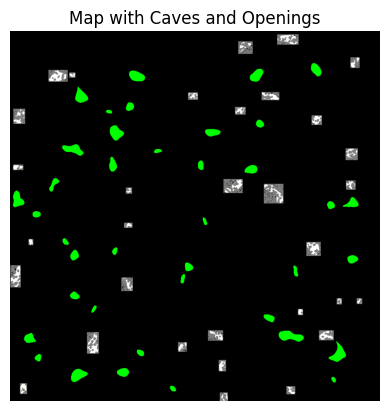

In [13]:
import matplotlib.pyplot as plt
from noise import pnoise2
from scipy.ndimage import label, find_objects
import random
from heapq import heappop, heappush

# Parameters for the 2D array
width, height = 1000, 1000
scale = 50.0


# Create two 2D arrays with Perlin noise to generate an organic shape
def generate_noise_array(width, height, scale, base):
    return np.array(
        [
            [
                pnoise2(
                    i / scale,
                    j / scale,
                    octaves=3,
                    persistence=0.4,
                    lacunarity=1.5,
                    base=base,
                )
                for j in range(width)
            ]
            for i in range(height)
        ]
    )


array1 = generate_noise_array(width, height, scale, base=42)
array2 = generate_noise_array(width, height, scale, base=24)

# Merge the two Perlin noise maps for more randomness
merged_array = (array1 + array2) / 2

# Plot the merged Perlin noise map
plt.imshow(merged_array, cmap="viridis")
plt.title("Merged Perlin Noise Map")
plt.axis("off")
plt.show()

# Threshold to create a natural shape (like an island or organic blob)
threshold = 0.2
organic_shape = merged_array > threshold

# Label connected regions and analyze cluster sizes
labeled_array, num_features = label(organic_shape)
objects = find_objects(labeled_array)

# Calculate sizes of all clusters and sort by size
cluster_sizes = [
    (i + 1, np.sum(labeled_array[obj_slice] == (i + 1)))
    for i, obj_slice in enumerate(objects)
]
cluster_sizes.sort(key=lambda x: x[1])

# Determine the size thresholds for top 80% and bottom 30%
num_clusters = len(cluster_sizes)
min_index = int(num_clusters * 0.25)
max_index = int(num_clusters * 0.95)

# Filter clusters to keep only those within the middle 50% range
filtered_shape = np.zeros_like(organic_shape)
for cluster_id, size in cluster_sizes[min_index:max_index]:
    filtered_shape[labeled_array == cluster_id] = 1

# Create a random color assignment for each blob (either grey or green)
final_shape = np.zeros((height, width, 3))
for cluster_id, _ in cluster_sizes[min_index:max_index]:
    color = [0.5, 0.5, 0.5] if random.random() < 0.5 else [0, 1, 0]  # Grey or Green
    final_shape[labeled_array == cluster_id] = color

# Plot the final shape with random colors
plt.imshow(final_shape)
plt.title("Full Map")
plt.axis("off")
plt.show()


# A* pathfinding implementation
class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heappush(self.elements, (priority, item))

    def get(self):
        return heappop(self.elements)[1]


def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])


def astar_path(cave_region, start, goal):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0

    while not frontier.empty():
        current = frontier.get()

        if current == goal:
            break

        for next in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            neighbor = (current[0] + next[0], current[1] + next[1])
            if (
                0 <= neighbor[0] < cave_region.shape[0]
                and 0 <= neighbor[1] < cave_region.shape[1]
            ):
                if cave_region[neighbor] == 1:  # Only move through open space
                    new_cost = cost_so_far[current] + 1
                    if neighbor not in cost_so_far or new_cost < cost_so_far[neighbor]:
                        cost_so_far[neighbor] = new_cost
                        priority = new_cost + heuristic(goal, neighbor)
                        frontier.put(neighbor, priority)
                        came_from[neighbor] = current

    # Reconstruct path
    current = goal
    path = []
    while current != start:
        if current not in came_from:
            return []  # If there's no valid path, return an empty list
        path.append(current)
        current = came_from[current]
    path.append(start)
    path.reverse()
    return path


# Generate cave within each grey region using Cellular Automata
grey_regions = [
    cluster_id
    for cluster_id, _ in cluster_sizes[min_index:max_index]
    if np.all(final_shape[labeled_array == cluster_id][0] == [0.5, 0.5, 0.5])
]

for cluster_id in grey_regions:
    obj_slice = objects[cluster_id - 1]
    grey_region = labeled_array[obj_slice] == cluster_id
    cave_region = np.random.choice(
        [0, 1], size=grey_region.shape, p=[0.45, 0.55]
    )  # Initial random fill (45% walls, 55% open)

    # Apply Cellular Automata rules for several generations
    for _ in range(5):  # Number of generations
        new_cave_region = np.copy(cave_region)
        for i in range(1, cave_region.shape[0] - 1):
            for j in range(1, cave_region.shape[1] - 1):
                if grey_region[i, j]:  # Only update cells within the grey region mask
                    # Count the number of neighboring walls
                    neighbor_sum = (
                        cave_region[i - 1, j - 1]
                        + cave_region[i - 1, j]
                        + cave_region[i - 1, j + 1]
                        + cave_region[i, j - 1]
                        + cave_region[i, j + 1]
                        + cave_region[i + 1, j - 1]
                        + cave_region[i + 1, j]
                        + cave_region[i + 1, j + 1]
                    )
                    if cave_region[i, j] == 1:
                        new_cave_region[i, j] = 1 if neighbor_sum >= 4 else 0
                    else:
                        new_cave_region[i, j] = 1 if neighbor_sum >= 5 else 0
        cave_region = new_cave_region

    # Ensure connectivity between white regions using A* algorithm
    labeled_cave, num_features = label(cave_region)
    if num_features > 1:
        centroids = [
            np.mean(np.argwhere(labeled_cave == label_id), axis=0).astype(int)
            for label_id in range(1, num_features + 1)
        ]
        for i in range(len(centroids) - 1):
            start = tuple(centroids[i])
            end = tuple(centroids[i + 1])
            path = astar_path(cave_region, start, end)
            if path:  # Only update if a valid path is found
                for r, c in path:
                    cave_region[r, c] = 1

    # Make the interior of the grey region into a cave-like structure (white is open space)
    # Preserve grey border by padding with 1 layer of grey (0.5) before applying to final shape
    padded_cave = np.pad(cave_region, pad_width=1, mode="constant", constant_values=0)
    grey_region_padded = np.pad(
        grey_region, pad_width=1, mode="constant", constant_values=0
    )

    final_shape[obj_slice][..., 0] = np.where(
        grey_region_padded[1:-1, 1:-1] & (padded_cave[1:-1, 1:-1] == 1),
        1,
        final_shape[obj_slice][..., 0],
    )
    final_shape[obj_slice][..., 1] = np.where(
        grey_region_padded[1:-1, 1:-1] & (padded_cave[1:-1, 1:-1] == 1),
        1,
        final_shape[obj_slice][..., 1],
    )
    final_shape[obj_slice][..., 2] = np.where(
        grey_region_padded[1:-1, 1:-1] & (padded_cave[1:-1, 1:-1] == 1),
        1,
        final_shape[obj_slice][..., 2],
    )

    # Set the grey boundary
    final_shape[obj_slice][..., 0] = np.where(
        (padded_cave[:-2, 1:-1] == 0)
        | (padded_cave[2:, 1:-1] == 0)
        | (padded_cave[1:-1, :-2] == 0)
        | (padded_cave[1:-1, 2:] == 0),
        0.5,
        final_shape[obj_slice][..., 0],
    )
    final_shape[obj_slice][..., 1] = np.where(
        (padded_cave[:-2, 1:-1] == 0)
        | (padded_cave[2:, 1:-1] == 0)
        | (padded_cave[1:-1, :-2] == 0)
        | (padded_cave[1:-1, 2:] == 0),
        0.5,
        final_shape[obj_slice][..., 1],
    )
    final_shape[obj_slice][..., 2] = np.where(
        (padded_cave[:-2, 1:-1] == 0)
        | (padded_cave[2:, 1:-1] == 0)
        | (padded_cave[1:-1, :-2] == 0)
        | (padded_cave[1:-1, 2:] == 0),
        0.5,
        final_shape[obj_slice][..., 2],
    )

# Create openings (in yellow) along the boundary of the grey regions
for cluster_id in grey_regions:
    obj_slice = objects[cluster_id - 1]
    grey_region = labeled_array[obj_slice] == cluster_id
    boundary_points = np.argwhere(grey_region)

    # Randomly select 1-7 boundary points to create openings (weighted towards 1)
    num_openings = random.choices(range(1, 8), weights=[50, 20, 10, 8, 6, 4, 2], k=1)[0]
    selected_points = boundary_points[
        random.sample(range(len(boundary_points)), num_openings)
    ]

    # Mark the openings in yellow
    for point in selected_points:
        if grey_region[
            point[0], point[1]
        ]:  # Ensure the point is within the grey region mask
            final_shape[obj_slice][point[0], point[1]] = [
                1,
                1,
                0,
            ]  # Yellow for openings

# Plot the final map with caves and openings
plt.imshow(final_shape)
plt.title("Map with Caves and Openings")
plt.axis("off")
plt.show()